In [3]:
import re
import os
import csv
import tensorflow as tf
import collections
import numpy as np

from transformers import (
    TFFlaubertForSequenceClassification,
    FlaubertTokenizer,
    FlaubertConfig
)

# Import dataset

In [5]:
config = FlaubertConfig.from_pretrained("jplu/tf-flaubert-base-cased")

In [6]:
categories = ['culture', 'france', 'international', 'santé', 'science_high-tech', 'sports', 'économie']
ner_labels = ["B-LOC", "B-MISC", "B-ORG", "B-PER", "I-LOC", "I-MISC", "I-ORG", "I-PER", "O"]
pos_labels = ["_", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]

In [64]:
def load_cache(cached_file, max_seq_length):    
    name_to_features = {
        "cls_token": tf.io.FixedLenFeature([config.emb_dim], tf.float32),
        "ner": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "pos": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "categorisation": tf.io.FixedLenFeature([len(categories)], tf.float32),
    }

    def _decode_record(record):
        example = tf.io.parse_single_example(record, name_to_features)
        features = {}
        features["cls_token"] = example["cls_token"]
        features["ner"] = example["ner"]
        features["pos"] = example["pos"]
        features["categorisation"] = example["categorisation"]
        return features, example["label_idx"]

    d = tf.data.TFRecordDataset(cached_file)
    d = d.map(_decode_record, num_parallel_calls=1)
    count = d.reduce(0, lambda x, _: x + 1)

    return d, count.numpy()

In [65]:
dataset, size = load_cache("./test_caching.tf_record", 64)

# Start training

In [66]:
X = []
for features, label in dataset.as_numpy_iterator():
    X.append(features["cls_token"])

In [105]:
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform([features["cls_token"] for features, _ in dataset.as_numpy_iterator()])

clustering = OPTICS(min_samples=25)

preds = clustering.fit_predict([features["cls_token"] for features, _ in dataset.as_numpy_iterator()])

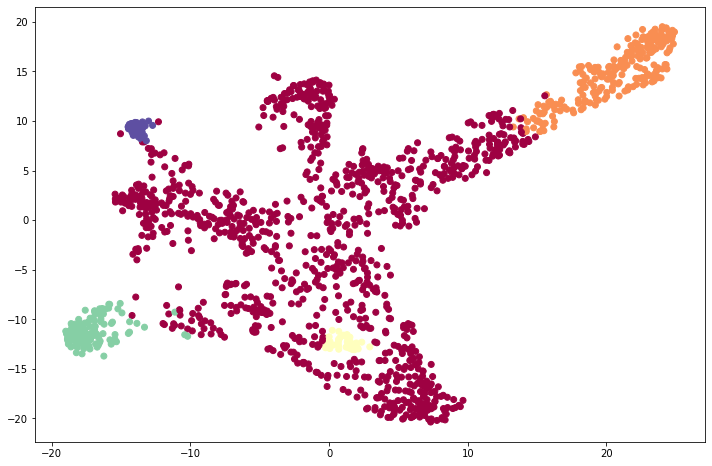

In [106]:
import matplotlib.pyplot as plt

plt.scatter(
    [a for a, _ in tsne_df],
    [b for _, b in tsne_df],
    c=preds,
    cmap="Spectral"
)

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)
plt.show()